<a href="https://www.kaggle.com/code/arthagrawal21/digits-classifier-vgg16?scriptVersionId=166822037" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [163]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [164]:
import shutil
import os
import random

# Path to the main "digits" folder
main_folder = "/kaggle/working/digits"

# Copy the entire "digits" folder to the working directory
#shutil.copytree("/kaggle/input/digits", main_folder)             Uncomment this line if Folder digits is not copied in Output of Kaggle

# Create "test" and "train" folders
os.makedirs(os.path.join(main_folder, "test"), exist_ok=True)
os.makedirs(os.path.join(main_folder, "train"), exist_ok=True)

# Split ratio for test/train data
test_ratio = 0.1  # 10%

# Iterate over subfolders (0 to 9)
for i in range(10):
    subfolder_path = os.path.join(main_folder, "Digits", "Digits", str(i))
    filenames = os.listdir(subfolder_path)
    random.shuffle(filenames)
    
    # Split the filenames into train and test sets
    test_size = int(len(filenames) * test_ratio)
    test_set = filenames[:test_size]
    train_set = filenames[test_size:]

    # Create subfolders for the current digit in the "test" and "train" folders
    os.makedirs(os.path.join(main_folder, "test", str(i)), exist_ok=True)
    os.makedirs(os.path.join(main_folder, "train", str(i)), exist_ok=True)

    # Move files to "test" folder
    for filename in test_set:
        src = os.path.join(subfolder_path, filename)
        dst = os.path.join(main_folder, "test", str(i), filename)
        shutil.move(src, dst)

    # Move files to "train" folder
    for filename in train_set:
        src = os.path.join(subfolder_path, filename)
        dst = os.path.join(main_folder, "train", str(i), filename)
        shutil.move(src, dst)

In [165]:
import os

# Path to the train folder
train_folder = '/kaggle/working/digits/train'

# Get the list of directories (digit labels)
train_directories = os.listdir(train_folder)

# Create a dictionary mapping directory name to digit label
dict_labels = {folder_name: int(folder_name) for folder_name in train_directories}

print(dict_labels)


{'4': 4, '8': 8, '6': 6, '5': 5, '1': 1, '2': 2, '7': 7, '0': 0, '3': 3, '9': 9}


In [166]:
def dataset(path):
    images = []
    labels = []
    failed_images = []

    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            try:
                image = cv2.imread(path_of_file)
                if image is None:
                    raise Exception(f"Failed to load image: {path_of_file}")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (150, 150))
                images.append(image)
                labels.append(value_of_label)
            except Exception as e:
                print(f"Failed to load image at path: {path_of_file}")
                failed_images.append(path_of_file)

    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)

    return images, labels, failed_images

images, labels, failed_images = dataset('/kaggle/working/digits/train')
images, labels = shuffle(images, labels)

# Display paths of failed images
print("Failed Images:")
for img_path in failed_images:
    print(img_path)
import os

file_path = '/kaggle/working/digits/train/6/img007-00930.png'

# Check if the file exists before attempting to remove it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' successfully removed.")
else:
    print(f"File '{file_path}' does not exist.")



 30%|███       | 3/10 [00:00<00:01,  6.64it/s]

Failed to load image at path: /kaggle/working/digits/train/6/img007-00930.png


100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


Failed Images:
/kaggle/working/digits/train/6/img007-00930.png
File '/kaggle/working/digits/train/6/img007-00930.png' successfully removed.


In [167]:
images.shape

(9008, 150, 150, 3)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


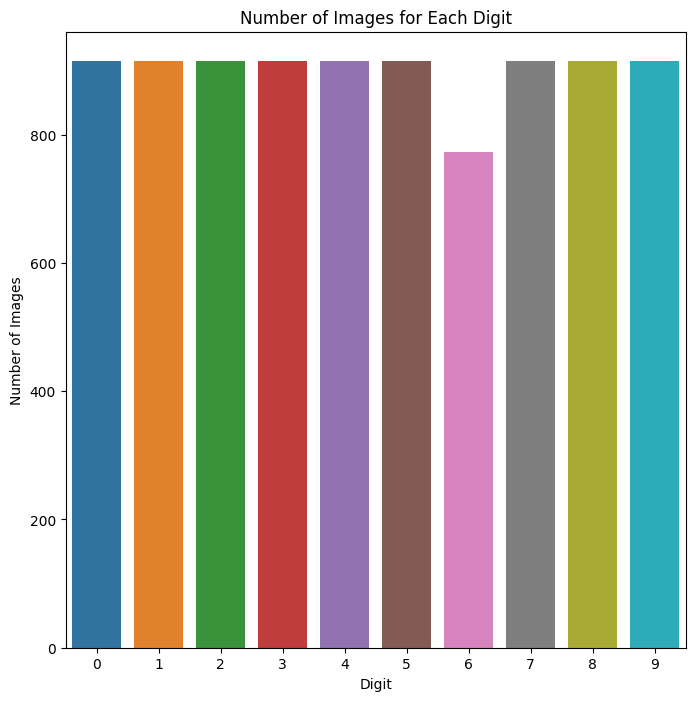

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of images for each digit
no_of_digits = []
for i in range(10):
    digit_folder = os.path.join('/kaggle/working/digits/train', str(i))
    no_of_images = len(os.listdir(digit_folder))
    no_of_digits.append(no_of_images)

# Plot the bar graph
plt.figure(figsize=(8, 8))
sns.barplot(x=list(range(10)), y=no_of_digits)
plt.xlabel('Digit')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Digit')
plt.show()


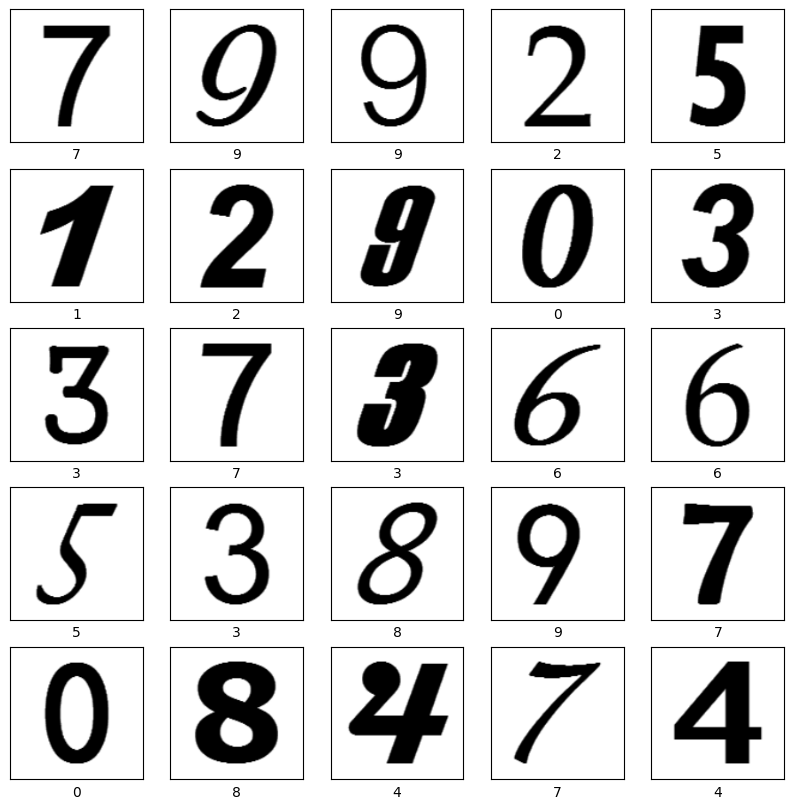

In [169]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(str(labels[i]))
plt.show()


In [170]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size
batch_size = 4

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate training and test sets
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/digits/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/digits/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 9008 images belonging to 10 classes.
Found 994 images belonging to 10 classes.


In [171]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [172]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, # Not including the Dense Layer
    input_shape = (224,224,3)
)

In [173]:
conv_base.trainable = False

In [174]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(120,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [175]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [176]:
history = model.fit(train_generator,epochs=11,validation_data=test_generator)

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   5/2252 ━━━━━━━━━━━━━━━━━━━━ 1:30 40ms/step - accuracy: 0.1342 - loss: 2.9068

W0000 00:00:1710328103.594377     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2252/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7224 - loss: 0.8660

W0000 00:00:1710328194.028135     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2252/2252 ━━━━━━━━━━━━━━━━━━━━ 108s 45ms/step - accuracy: 0.7225 - loss: 0.8658 - val_accuracy: 0.9567 - val_loss: 0.1261
Epoch 2/11


W0000 00:00:1710328205.469964     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2252/2252 ━━━━━━━━━━━━━━━━━━━━ 96s 43ms/step - accuracy: 0.9353 - loss: 0.2183 - val_accuracy: 0.9718 - val_loss: 0.0902
Epoch 3/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - accuracy: 0.9577 - loss: 0.1480 - val_accuracy: 0.9859 - val_loss: 0.0453
Epoch 4/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - accuracy: 0.9594 - loss: 0.1426 - val_accuracy: 0.9839 - val_loss: 0.0474
Epoch 5/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - accuracy: 0.9660 - loss: 0.1336 - val_accuracy: 0.9678 - val_loss: 0.0940
Epoch 6/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - accuracy: 0.9725 - loss: 0.1063 - val_accuracy: 0.9869 - val_loss: 0.0437
Epoch 7/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 95s 42ms/step - accuracy: 0.9759 - loss: 0.0858 - val_accuracy: 0.9889 - val_loss: 0.0247
Epoch 8/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - accuracy: 0.9773 - loss: 0.0933 - val_accuracy: 0.9648 - val_loss: 0.1778
Epoch 9/11
2252/2252 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - accuracy: 0.9712 - loss: 0.09

In [193]:
model.save("digits_classifier_vgg16.h5")

ValueError: Unable to synchronously create dataset (name already exists)

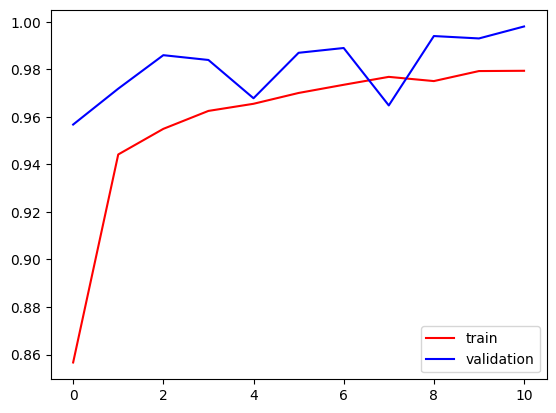

In [194]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

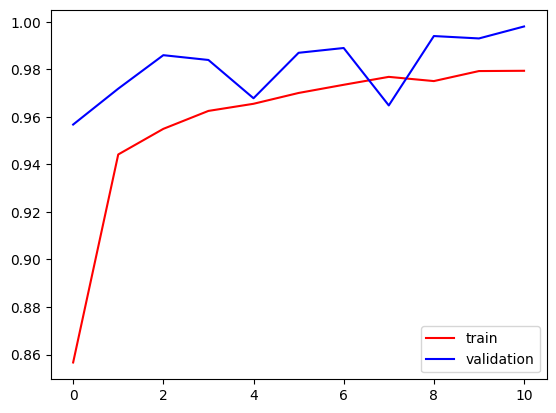

In [195]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [196]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [198]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype='float32') / 255.0
    plt.imshow(image)
    image = image.reshape(1, 224, 224, 3)
    
    label_names = train_generator.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    predictions = model.predict(image)
    clas = predictions.argmax()
    probability = predictions[0][clas]
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nDigit: {1} \nProbability: {2:.2f}%'.format(clas, name, probability * 100))

In [203]:
import requests
import shutil

# URL of the image you want to download
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Eo_circle_red_number-4.svg/2048px-Eo_circle_red_number-4.svg.png"

# Download the image
response = requests.get(url, stream=True)
with open('/kaggle/working/image.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

# Use the predictor function with the downloaded image
predictor('/kaggle/working/image.jpg', model)


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [208]:
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO

def download_image(url, save_path):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    if image.mode == 'P':
        image = image.convert('RGB')
    image.save(save_path)

def predictor(img, model):
    image = cv2.imread(img)
    if image is None:
        print("Error loading image.")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype='float32') / 255.0
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    print("Prediction:", prediction)
    print("Prediction:")
    for i, prob in enumerate(prediction[0]):
        print(f"Class {i}: {prob:.4f}")


# Example usage
image_url_short = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRWCNh28CZPQH1kd-Ltm3ivagNdCQ-C5CwmeQ&usqp=CAU"
image_url_long = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Eo_circle_red_number-4.svg/2048px-Eo_circle_red_number-4.svg.png"
save_path = '/kaggle/working/image.jpg'

# Download and save the image
download_image(image_url_short, save_path)

# Use the predictor function with the downloaded image
predictor(save_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: [[4.1034107e-32 2.7034958e-10 7.0938344e-20 3.1608532e-35 1.0000000e+00
  4.6646655e-30 1.6297539e-17 1.7793491e-16 1.6061236e-30 8.6258963e-17]]
Prediction:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 1.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000
